# Build a lenear model with Estimators

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [2]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [6]:
# Load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [7]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [10]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [12]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

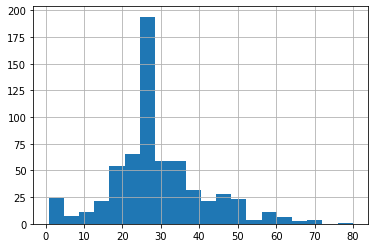

In [15]:
dftrain.age.hist(bins=20)

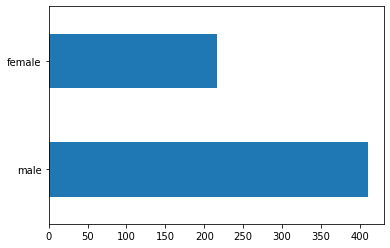

In [17]:
dftrain.sex.value_counts().plot(kind='barh')

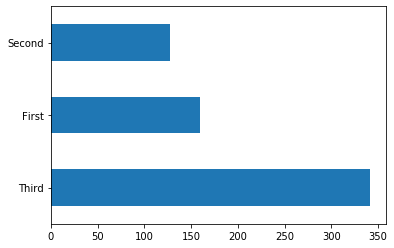

In [18]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

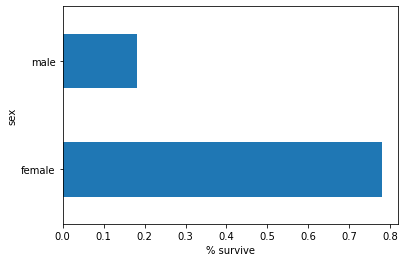

In [25]:
pd.concat([dftrain, y_train], axis=1).groupby('sex')['survived'].mean().plot(kind='barh').set_xlabel('% survive')

In [28]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_column in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_column, dtype=tf.float32))

In [62]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [63]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'First' b'Third' b'Second' b'First' b'Second' b'First' b'Second'
 b'First' b'Third' b'First']

A batch of Labels: [0 0 0 0 0 0 0 1 1 1]


In [68]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

W0625 17:28:50.810586 4513764800 base_layer.py:1790] Layer dense_features is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W0625 17:28:50.817403 4513764800 deprecation.py:323] From /Users/luke/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/feature_column/feature_column_v2.py:4267: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feat

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [71]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.80719316, 'auc_precision_recall': 0.765344, 'average_loss': 0.5265564, 'label/mean': 0.375, 'loss': 0.5167772, 'precision': 0.7468355, 'prediction/mean': 0.3077798, 'recall': 0.5959596, 'global_step': 200}


Derived Feature Columns

In [72]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [74]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7651515, 'accuracy_baseline': 0.625, 'auc': 0.84937245, 'auc_precision_recall': 0.7824917, 'average_loss': 0.46378508, 'label/mean': 0.375, 'loss': 0.4553803, 'precision': 0.69072163, 'prediction/mean': 0.37867308, 'recall': 0.67676765, 'global_step': 200}


W0625 17:55:18.385316 4513764800 base_layer.py:1790] Layer linear/linear_model is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



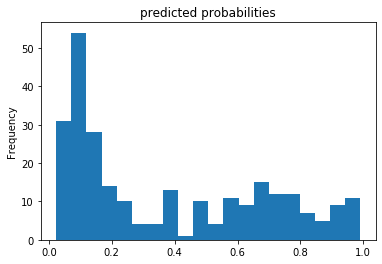

In [77]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [76]:
pred_dicts

[{'logits': array([-2.2284517], dtype=float32),
  'logistic': array([0.09722445], dtype=float32),
  'probabilities': array([0.9027755 , 0.09722445], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-0.4583702], dtype=float32),
  'logistic': array([0.38737252], dtype=float32),
  'probabilities': array([0.61262745, 0.38737252], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([0.773837], dtype=float32),
  'logistic': array([0.6843503], dtype=float32),
  'probabilities': array([0.31564966, 0.6843503 ], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 

In [78]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

(0, 1.05)

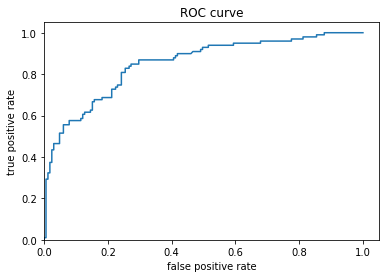

In [79]:
fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)